In [1]:
import pandas as pd
import os
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from tqdm import  tqdm
import logging
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
def match(df_1, df_2, pixel, df1_name):
    """
    match two catalog
    :param df_1:
    :param df_2:
    :return:
    """
    sdss = SkyCoord(ra=df_1.ra * u.degree, dec=df_1.dec * u.degree)
    decals = SkyCoord(ra=df_2.ra * u.degree, dec=df_2.dec * u.degree)
    idx, d2d, d3d = sdss.match_to_catalog_sky(decals)
    max_sep = pixel * 0.262 * u.arcsec
    distance_idx = d2d < max_sep

    sdss_matches = df_1.iloc[distance_idx]
    matches = idx[distance_idx]
    decal_matches = df_2.iloc[matches]
    test = sdss_matches.loc[:].rename(columns={"ra":"%s" % df1_name[0], "dec":"%s" % df1_name[1]})
    test.insert(0, 'ID', range(len(test)))
    decal_matches.insert(0, 'ID', range(len(decal_matches)))
    new_df = pd.merge(test, decal_matches, how="inner", on=["ID"])
    return new_df.drop("ID", axis=1)
def extract_questions_and_label_cols(question_answer_pairs):
    """
    Convenience wrapper to get list of questions and label_cols from a schema.
    Common starting point for analysis, iterating over questions, etc.

    Args:
        question_answer_pairs (dict): e.g. {'smooth-or-featured: ['_smooth, _featured-or-disk, ...], ...}

    Returns:
        list: all questions e.g. [Question('smooth-or-featured'), ...]
        list: label_cols (list of answer strings). See ``label_metadata.py`` for examples.
    """
    questions = list(question_answer_pairs.keys())
    label_cols = [q + answer for q, answers in question_answer_pairs.items() for answer in answers]
    return questions, label_cols
class Question():

    def __init__(self, question_text:str, answer_text: List, label_cols:List):
        """
        Class representing decision tree question.
        Requires ``label_cols`` as an input in order to find the index (vs. all questions and answers) of this question and each answer.

        Args:
            question_text (str): e.g. 'smooth-or-featured'
            answer_text (List): e.g. ['smooth', 'featured-or-disk]
            label_cols (List): list of all questions and answers e.g. ['smooth-or-featured_smooth', 'smooth-or-featured_featured-or-disk', ...]
        """
        self.text = question_text
        self.answers = create_answers(self, answer_text, label_cols)  # passing a reference to self, will stay up-to-date

        self.start_index = min(a.index for a in self.answers)
        self.end_index = max(a.index for a in self.answers)
        assert [self.start_index <= a.index <= self.end_index for a in self.answers]

        self._asked_after = None

    @property
    def asked_after(self):
        return self._asked_after

    def __repr__(self):
        return f'{self.text}, indices {self.start_index} to {self.end_index}, asked after {self.asked_after}'
class Answer():

    def __init__(self, text, question, index):
        """
        Class representing decision tree answer.

        Each answer includes the answer text (often used as a column header),
        the corresponding question, and its index in ``label_cols`` (often used for slicing model outputs)

        Args:
            text (str): e.g. 'smooth-or-featured_smooth'
            question (Question): Question class for this answer
            index (int): index of answer in label_cols (0-33 for DECaLS)
        """
        self.text = text
        self.question = question

        self.index = index
        self._next_question = None

    @property
    def next_question(self):
        """

        Returns:
            Question: question that follows after this answer. None initially, added by ``set_dependancies``.
        """
        return self._next_question

    def __repr__(self):
        return f'{self.text}, index {self.index}'

    @property
    def pretty_text(self):
        """
        Returns:
            str: Nicely formatted text for plots etc
        """
        return self.text.replace('-',' ').replace('_', ' ').title()
def create_answers(question:Question, answers_texts:List, label_cols:List):
    """
    Instantiate the Answer classes for a given ``Question``.
    Each answer includes the answer text (often used as a column header),
    the corresponding question, and its index in ``label_cols`` (often used for slicing model outputs)

    Args:
        question (Question): question to which to create answers e.g. Question(smooth-or-featured)
        answers_texts (List): answer strings e.g. ['smooth-or-featured_smooth', 'smooth-or-featured_featured-or-disk']
        label_cols (List): list of all questions and answers e.g. ['smooth-or-featured_smooth', 'smooth-or-featured_featured-or-disk', ...]

    Returns:
        List: of Answers to that question e.g. [Answer(smooth-or-featured_smooth), Answer(smooth-or-featured_featured-or-disk)]
    """
    question_text = question.text
    answers = []
    for answer_text in answers_texts:
        answers.append(
            Answer(
                text=question_text + answer_text,  # e.g. smooth-or-featured_smooth
                question=question,
                index=label_cols.index(question_text + answer_text)  # will hopefully throw value error if not found?
                # _next_question not set, set later with dependancies
            )
        )
    return answers
def set_dependencies(questions, dependencies):
    """
    Link each answer to question which follows, and vica versa.
    Acts inplace.

    Specifically, for every answer in every question, set answer._next question to refer to the Question which follows that answer.
    Then for that Question, set question._asked_after to that answer.

    Args:
        questions (List): of questions e.g. [Question('smooth-or-featured'), Question('edge-on-disk')]
        dependencies (dict): dict mapping each question (e.g. disk-edge-on) to the answer on which it depends (e.g. smooth-or-featured_featured-or-disk)
    """

    for question in questions:
        prev_answer_text = dependencies[question.text]
        if prev_answer_text is not None:
            try:
                prev_answer = [a for q in questions for a in q.answers if a.text == prev_answer_text][0]  # look through every answer, find those with the same text as "prev answer text" - will be exactly one match
            except IndexError:
                raise ValueError(f'{prev_answer_text} not found in dependencies')
            prev_answer._next_question = question
            question._asked_after = prev_answer
class Schema():
    def __init__(self, question_answer_pairs:dict, dependencies):
        """
        Relate the df label columns tor question/answer groups and to tfrecod label indices
        Requires that labels be continguous by question - easily satisfied

        Args:
            question_answer_pairs (dict): e.g. {'smooth-or-featured: ['_smooth, _featured-or-disk, ...], ...}
            dependencies (dict): dict mapping each question (e.g. disk-edge-on) to the answer on which it depends (e.g. smooth-or-featured_featured-or-disk)
        """
        logging.debug(f'Q/A pairs: {question_answer_pairs}')
        self.question_answer_pairs = question_answer_pairs
        _, self.label_cols = extract_questions_and_label_cols(question_answer_pairs)
        self.dependencies = dependencies
        """
        Be careful:
        - first entry should be the first answer to that question, by df column order
        - second entry should be the last answer to that question, similarly
        - answers in between will be included: these are used to slice
        - df columns must be contigious by question (e.g. not smooth_yes, bar_no, smooth_no) for this to work!
        """
        self.questions = [Question(question_text, answers_text, self.label_cols) for question_text, answers_text in question_answer_pairs.items()]
        if len(self.questions) > 1:
            set_dependencies(self.questions, self.dependencies)

        assert len(self.question_index_groups) > 0
        assert len(self.questions) == len(self.question_index_groups)


    def get_answer(self, answer_text):
        """

        Args:
            answer_text (str): e.g. 'smooth-or-featured_smooth'

        Raises:
            ValueError: No answer with that answer_text found

        Returns:
            Answer: the answer with matching answer_text e.g. Answer('smooth-or-featured_smooth')
        """
        try:
            return [a for q in self.questions for a in q.answers if a.text == answer_text][0]  # will be exactly one match
        except IndexError:
            raise ValueError('Answer not found: ', answer_text)


    def get_question(self, question_text):
        """

        Args:
            question_text (str): e.g. 'smooth-or-featured'

        Raises:
            ValueError: No question with that question_text found

        Returns:
            Question: the question with matching question_text e.g. Question('smooth-or-featured')
        """
        try:
            return [q for q in self.questions if q.text == question_text][0]  # will be exactly one match
        except  IndexError:
            raise ValueError('Question not found: ', question_text)


    @property
    def question_index_groups(self):
        """

        Returns:
            Paired (tuple) integers of (first, last) indices of answers to each question, listed for all questions.
            Useful for slicing model predictions by question.
        """
         # start and end indices of answers to each question in label_cols e.g. [[0, 1]. [1, 3]]
        return [(q.start_index, q.end_index) for q in self.questions]


    @property
    def named_index_groups(self):
        """

        Returns:
            dict: mapping each question to the start and end index of its answers in label_cols, e.g. {Question('smooth-or-featured'): [0, 2], ...}
        """
        return dict(zip(self.questions, self.question_index_groups))


    def joint_p(self, prob_of_answers, answer_text):
        """
        Probability of the answer with ``answer_text`` being asked, given the (predicted) probability of every answer.
        Useful for estimating the relevance of an answer e.g. to ignore predictons for answers less than 50% likely to be asked.

        Broadcasts over batch dimension.

        Args:
            prob_of_answers (np.ndarray): prob. of each answer being asked, of shape (galaxies, answers) where the index of answers matches label_cols
            answer_text (str): which answer to find the prob. of being asked e.g. 'edge-on-disk_yes'

        Returns:
            np.ndarray: prob of that answer being asked e.g. 0.5 for 'edge-on-disk_yes' of prob of 'smooth-or-featured_featured-or-disk' is 0.5. Shape (galaxies).
        """
        assert prob_of_answers.ndim == 2  # batch, p. No 'per model', marginalise first
        # prob(answer) = p(that answer|that q asked) * p(that q_asked) i.e...
        # prob(answer) = p(that answer|that q asked) * p(answer before that q)
        answer = self.get_answer(answer_text)
        p_answer_given_question = prob_of_answers[:, answer.index]
        if all(np.isnan(p_answer_given_question)):
            logging.warning(f'All p_answer_given_question for {answer_text} ({answer.index}) are nan i.e. all fractions are nan - check that labels for this question are appropriate')

        question = answer.question
        prev_answer = question.asked_after
        if prev_answer is None:
            return p_answer_given_question
        else:
            p_prev_answer = self.joint_p(prob_of_answers, prev_answer.text)  # recursive
            return p_answer_given_question * p_prev_answer


    @property
    def answers(self):
        """

        Returns:
            list: all answers
        """
        answers = []
        for q in self.questions:
            for a in q.answers:
                answers.append(a)
        return answers

In [2]:
"""测试overlap的数据集"""
with open("/data/renhaoye/mw_valid.txt", "r") as r:
    valid = r.readlines()
    valid_df = []
    for i in range(len(valid)):
        ra, dec = valid[i].split(".fits")[0].split("agmtn/")[1].split("_")
        valid_df.append([float(ra), float(dec)])
with open("/data/renhaoye/mw_train.txt", "r") as r:
    train = r.readlines()
    train_df = []
    for i in range(len(train)):
        if "rotated" not in train[i] and "shifted" not in train[i] and "flipped" not in train[i]:
            ra, dec = train[i].split(".fits")[0].split("agmtn/")[1].split("_")
            train_df.append([float(ra), float(dec)])
with open("/data/renhaoye/mw_test.txt", "r") as r:
    test = r.readlines()
    test_df = []
    for i in range(len(test)):
        ra, dec = test[i].split(".fits")[0].split("agmtn/")[1].split("_")
        test_df.append([float(ra), float(dec)])

In [3]:
# load local file names to pd.Dataframe to match, in_decals, ls-9-south
# these data are in MGS
local_files = os.listdir("/data/renhaoye/MorCG/dataset/out_decals/scaled/")
ra, dec = [], []
for i in tqdm(range(len(local_files))):
    if ".fits" in local_files[i]:
        t_ra, t_dec= float(local_files[i].split("_")[0]), float(local_files[i].split("_")[1].split(".fits")[0])
        ra.append(t_ra)
        dec.append(t_dec)
out_decals = pd.DataFrame(list(zip(ra, dec)), columns=["ra", "dec"])

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 259323/259323 [00:00<00:00, 533737.43it/s]


In [4]:
train[0]

'/data/renhaoye/MorCG/dataset/in_decals/agmtn/177.13588639859063_0.23091051851496017.fits label:23 56 11 55 1 0 1 0 1 0 0 0 0 1 0 1 1 21 1 14 40 0 0 0 0 0 0 0 0 0 59 16 1 3  \n'

In [5]:
mw_overlap_train = match(pd.DataFrame(train_df, columns=["ra", "dec"]), out_decals, 2, df1_name=["out_ra", "out_dec"]).drop(columns=["ra", "dec"])
mw_overlap_train = mw_overlap_train.rename(columns={"out_ra":"ra", "out_dec":"dec"})

mw_overlap_valid = match(pd.DataFrame(valid_df, columns=["ra", "dec"]), out_decals, 2, df1_name=["out_ra", "out_dec"]).drop(columns=["ra", "dec"])
mw_overlap_valid = mw_overlap_valid.rename(columns={"out_ra":"ra", "out_dec":"dec"})

mw_overlap_test = match(pd.DataFrame(test_df, columns=["ra", "dec"]), out_decals, 2, df1_name=["out_ra", "out_dec"]).drop(columns=["ra", "dec"])
mw_overlap_test = mw_overlap_test.rename(columns={"out_ra":"ra", "out_dec":"dec"})

In [8]:
def get_overlap(mw, out_decals, w):
    overlap = []
    for i in tqdm(range(len(mw))):
        # print(mw[i].split(".fits")[0])
        if "rotated" not in mw[i] and "shifted" not in mw[i] and "flipped" not in mw[i]:
            ra, dec = mw[i].split(".fits")[0].split("agmtn/")[1].split("_")
            if float(ra) in out_decals["ra"].values and float(dec) in out_decals["dec"].values:
                w.writelines(mw[i])

In [10]:
with open("/data/renhaoye/mw_overlap_train.txt", "w+") as w:
    get_overlap(train, mw_overlap_train, w)
with open("/data/renhaoye/mw_overlap_valid.txt", "w+") as w:
    get_overlap(valid, mw_overlap_valid, w)
with open("/data/renhaoye/mw_overlap_test.txt", "w+") as w:
    get_overlap(test, mw_overlap_test, w)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 17703/17703 [00:00<00:00, 88985.12it/s]


In [21]:
mw_overlap_test = match(out_decals, x, 2, df1_name=["out_ra", "out_dec"]).drop(columns=["ra", "dec"])
mw_overlap_test = mw_overlap_test.rename(columns={"out_ra":"ra", "out_dec":"dec"})

In [26]:
with open("/data/renhaoye/mw_overlap_test.txt", "w+") as w:
    for i in range(len(mw_overlap_test)):
        path = "/data/renhaoye/MorCG/dataset/out_decals/scaled/" + str(mw_overlap_test.iloc[i, 0]) + "_" + str(mw_overlap_test.iloc[i, 1]) + ".fits"
        if os.path.exists(path):
            w.writelines(path + "\n")

In [23]:
mw_overlap_test.iloc[0,0]

156.40467755841246

In [2]:
# load local file names to pd.Dataframe to match, in_decals, ls-9-south
# these data are in MGS
local_files = os.listdir("/data/renhaoye/MorCG/dataset/in_decals/raw_fits/")
ra, dec = [], []
for i in tqdm(range(len(local_files))):
    if ".fits" in local_files[i]:
        t_ra, t_dec= float(local_files[i].split("_")[0]), float(local_files[i].split("_")[1].split(".fits")[0])
        ra.append(t_ra)
        dec.append(t_dec)
in_decals = pd.DataFrame(list(zip(ra, dec)), columns=["ra", "dec"])

100%|███████████████████████████████████████████████████████████████████████| 359209/359209 [00:00<00:00, 521070.92it/s]


In [3]:
df_c = pd.read_csv("/data/renhaoye/MorCG/dataset/mw_catalog.csv", index_col=0).rename(columns=lambda x: x.replace("-", "_")).fillna(0)
new_c = match(in_decals, df_c, 2, df1_name=["in_ra", "in_dec"]).drop(columns=["ra", "dec"])
new_c = new_c.rename(columns={"in_ra":"ra", "in_dec":"dec"})
new_c

,ra,dec,iauname,redshift,elpetro_absmag_r,sersic_nmgy_r,petro_th50,petro_th90,petro_theta,upload_group,...,spiral_arm_count_cant_tell_fraction,merging_total_votes,merging_none,merging_none_fraction,merging_minor_disturbance,merging_minor_disturbance_fraction,merging_major_disturbance,merging_major_disturbance_fraction,merging_merger,merging_merger_fraction
0,156.404678,32.128263,J102537.12+320741.7,0.037345,-20.225850,1243.06240,3.405226,11.521922,7.807667,active_baseline,...,0.000000,4,4,1.000000,0,0.000000,0,0.000000,0,0.000000
1,156.028195,10.281041,J102406.76+101651.7,0.097509,-22.320599,936.65620,2.819223,9.270042,6.501150,active_baseline,...,0.000000,5,5,1.000000,0,0.000000,0,0.000000,0,0.000000
2,41.000599,-8.739704,J024400.14-084422.9,0.043265,-18.766365,168.72968,1.878542,4.701300,3.856986,pre_active,...,0.000000,39,22,0.564103,5,0.128205,1,0.025641,1,0.025641
3,236.876370,0.425387,J154730.33+002531.4,0.033443,-18.320585,198.22293,4.248001,9.377006,8.806542,pre_active,...,0.176471,39,13,0.333333,9,0.230769,6,0.153846,6,0.153846
4,233.329425,7.594146,J153319.06+073538.9,0.077317,-19.721277,120.08225,1.563657,3.970353,3.434981,active_baseline,...,0.000000,14,14,1.000000,0,0.000000,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140926,230.296703,32.045519,J152111.21+320243.8,0.108780,-20.668434,156.51578,2.007320,6.901734,4.871721,active_baseline,...,0.000000,5,4,0.800000,0,0.000000,1,0.200000,0,0.000000
140927,195.551590,9.423554,J130212.37+092524.7,0.084402,-19.926037,121.65462,2.078999,4.724053,4.289220,active_baseline,...,0.000000,5,5,1.000000,0,0.000000,0,0.000000,0,0.000000
140928,141.485652,7.017201,J092556.55+070101.9,0.079930,-20.020388,165.25545,1.497167,4.106831,3.336901,pre_active,...,0.000000,36,35,0.972222,1,0.027778,0,0.000000,0,0.000000
140929,138.774497,3.585291,J091505.87+033507.0,0.098247,-21.397547,441.90793,4.975659,10.416905,9.129296,active_baseline,...,0.000000,3,1,0.333333,0,0.000000,0,0.000000,2,0.666667


In [4]:
df = new_c.query("smooth_or_featured_total_votes >= 35 | disk_edge_on_total_votes >=35 | has_spiral_arms_total_votes >= 35 | bar_total_votes >=35 | bulge_size_total_votes >=35 | how_rounded_total_votes >= 35 | edge_on_bulge_total_votes >= 35 | spiral_winding_total_votes >= 35 | spiral_arm_count_total_votes >= 35 | merging_total_votes >= 35")

In [5]:
df = df.query("upload_group == 'active_baseline' | upload_group == 'pre_active'")
df

,ra,dec,iauname,redshift,elpetro_absmag_r,sersic_nmgy_r,petro_th50,petro_th90,petro_theta,upload_group,...,spiral_arm_count_cant_tell_fraction,merging_total_votes,merging_none,merging_none_fraction,merging_minor_disturbance,merging_minor_disturbance_fraction,merging_major_disturbance,merging_major_disturbance_fraction,merging_merger,merging_merger_fraction
2,41.000599,-8.739704,J024400.14-084422.9,0.043265,-18.766365,168.72968,1.878542,4.701300,3.856986,pre_active,...,0.000000,39,22,0.564103,5,0.128205,1,0.025641,1,0.025641
3,236.876370,0.425387,J154730.33+002531.4,0.033443,-18.320585,198.22293,4.248001,9.377006,8.806542,pre_active,...,0.176471,39,13,0.333333,9,0.230769,6,0.153846,6,0.153846
5,172.144934,-0.902718,J112834.77-005409.7,0.061606,-19.711222,196.61601,1.556126,4.227541,3.385585,pre_active,...,0.000000,71,42,0.591549,2,0.028169,1,0.014085,2,0.028169
6,172.474041,3.328802,J112953.76+031943.6,0.108252,-20.858261,178.25711,2.019637,5.566817,4.479708,pre_active,...,0.000000,38,26,0.684211,4,0.105263,0,0.000000,8,0.210526
9,173.658262,0.352565,J113437.98+002109.2,0.099754,-20.594330,164.51930,3.013735,6.721991,6.410168,pre_active,...,0.301887,76,60,0.789474,10,0.131579,5,0.065789,1,0.013158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140918,164.661240,9.793845,J105838.69+094737.8,0.063569,-20.125134,366.42180,3.501963,8.073513,7.473316,pre_active,...,0.200000,33,29,0.878788,1,0.030303,3,0.090909,0,0.000000
140920,200.502041,-3.547125,J132200.48-033249.7,0.086841,-21.058382,350.42703,2.683366,9.033441,6.616400,pre_active,...,0.000000,32,11,0.343750,7,0.218750,2,0.062500,0,0.000000
140922,174.044885,-2.527951,J113610.76-023140.5,0.042936,-19.695190,447.70930,4.664875,11.924413,10.695853,pre_active,...,0.000000,34,0,0.000000,0,0.000000,0,0.000000,0,0.000000
140923,170.286546,0.626590,J112108.77+003735.7,0.133738,-21.016005,118.32811,1.965388,5.329020,4.314844,pre_active,...,0.000000,78,22,0.282051,37,0.474359,17,0.217949,2,0.025641


In [7]:
train, hidden = train_test_split(df, train_size=0.7, random_state=1926)
val, test = train_test_split(hidden, train_size=0.5, random_state=1926)

In [8]:
gz2_pairs = {
    'smooth_or_featured': ['_smooth', '_featured_or_disk', '_artifact'],
    'disk_edge_on': ['_yes', '_no'],
    'has_spiral_arms': ['_yes', '_no'],
    'bar': ['_strong', '_weak', '_no'],
    'bulge_size': ['_dominant', '_large', '_moderate', '_small', '_none'],
    'how_rounded': ['_round', '_in_between', '_cigar_shaped'],
    'edge_on_bulge': ['_boxy', '_none', '_rounded'], # de
    'spiral_winding': ['_tight', '_medium', '_loose'],
    'spiral_arm_count': ['_1', '_2', '_3', '_4', '_more_than_4', '_cant_tell'],
    'merging': ['_none', '_minor_disturbance', '_major_disturbance', '_merger'] # de
}
gz2_and_decals_dependencies = {
    'smooth_or_featured': None,  # always asked
    'disk_edge_on': 'smooth_or_featured_featured_or_disk',
    'has_spiral_arms': 'smooth_or_featured_featured_or_disk',
    'bar': 'smooth_or_featured_featured_or_disk',
    'bulge_size': 'smooth_or_featured_featured_or_disk',
    'how_rounded': 'smooth_or_featured_smooth',
    'edge_on_bulge': 'disk_edge_on_yes',
    'spiral_winding': 'has_spiral_arms_yes',
    'spiral_arm_count': 'has_spiral_arms_yes', # bad naming...
    'merging': None,
}

In [9]:
question_answer_pairs = gz2_pairs  # 问题？
dependencies = gz2_and_decals_dependencies
schema = Schema(question_answer_pairs, dependencies)
label_cols = schema.label_cols
def get_galaxy_label(galaxy, label_cols):
    # no longer casts to int64, user now responsible in df. If dtype is mixed, will try to infer with infer_objects
    return galaxy[label_cols].infer_objects().values.squeeze()  # squeeze for if there's one label_col
# def get_label(catalog, i):
#     galaxy = catalog.iloc[i]
#     label = get_galaxy_label(galaxy, label_cols)
#     x = np.array(list(label))
#     new = []
#     if x[0:3].sum() != 0:
#         new.append(x[0]/x[0:3].sum())
#         new.append(x[1]/x[0:3].sum())
#         new.append(x[2]/x[0:3].sum())
#     else:
#         new.append(0)
#         new.append(0)
#         new.append(0)
#
#     if x[3:5].sum() != 0:
#         new.append(x[3]/x[3:5].sum())
#         new.append(x[4]/x[3:5].sum())
#     else:
#         new.append(0)
#         new.append(0)
#
#     if x[5:7].sum() != 0:
#         new.append(x[5]/x[5:7].sum())
#         new.append(x[6]/x[5:7].sum())
#     else:
#         new.append(0)
#         new.append(0)
#
#     if x[7:10].sum() != 0:
#         new.append(x[7]/x[7:10].sum())
#         new.append(x[8]/x[7:10].sum())
#         new.append(x[9]/x[7:10].sum())
#     else:
#         new.append(0)
#         new.append(0)
#         new.append(0)
#
#     if x[10:15].sum() != 0:
#         new.append(x[10]/x[10:15].sum())
#         new.append(x[11]/x[10:15].sum())
#         new.append(x[12]/x[10:15].sum())
#         new.append(x[13]/x[10:15].sum())
#         new.append(x[14]/x[10:15].sum())
#     else:
#         new.append(0)
#         new.append(0)
#         new.append(0)
#         new.append(0)
#         new.append(0)
#
#     if x[15:18].sum() != 0:
#         new.append(x[15]/x[15:18].sum())
#         new.append(x[16]/x[15:18].sum())
#         new.append(x[17]/x[15:18].sum())
#     else:
#         new.append(0)
#         new.append(0)
#         new.append(0)
#
#     if x[18:21].sum() != 0:
#         new.append(x[18]/x[18:21].sum())
#         new.append(x[19]/x[18:21].sum())
#         new.append(x[20]/x[18:21].sum())
#     else:
#         new.append(0)
#         new.append(0)
#         new.append(0)
#
#
#     if x[21:27].sum() != 0:
#         new.append(x[21]/x[21:27].sum())
#         new.append(x[22]/x[21:27].sum())
#         new.append(x[23]/x[21:27].sum())
#         new.append(x[24]/x[21:27].sum())
#         new.append(x[25]/x[21:27].sum())
#         new.append(x[26]/x[21:27].sum())
#     else:
#         new.append(0)
#         new.append(0)
#         new.append(0)
#         new.append(0)
#         new.append(0)
#         new.append(0)
#     return new

In [10]:
train

,ra,dec,iauname,redshift,elpetro_absmag_r,sersic_nmgy_r,petro_th50,petro_th90,petro_theta,upload_group,...,spiral_arm_count_cant_tell_fraction,merging_total_votes,merging_none,merging_none_fraction,merging_minor_disturbance,merging_minor_disturbance_fraction,merging_major_disturbance,merging_major_disturbance_fraction,merging_merger,merging_merger_fraction
92163,177.135886,0.230911,J114832.60+001351.2,0.047092,-19.589610,342.54166,4.066227,11.992848,8.957146,pre_active,...,0.000000,79,59,0.746835,16,0.202532,1,0.012658,3,0.037975
98321,183.910549,12.219594,J121538.53+121310.5,0.064737,-20.595457,403.88904,4.871721,10.639151,10.527441,active_baseline,...,0.000000,5,2,0.400000,2,0.400000,0,0.000000,1,0.200000
32728,12.758618,0.676311,J005102.07+004034.7,0.114842,-20.796616,154.99489,1.586471,4.633696,3.801523,pre_active,...,0.000000,37,28,0.756757,1,0.027027,0,0.000000,0,0.000000
134021,230.021889,30.325420,J152005.25+301931.5,0.065126,-19.457094,165.63030,1.633101,4.545066,3.535943,active_baseline,...,0.000000,5,5,1.000000,0,0.000000,0,0.000000,0,0.000000
71119,173.704833,-1.063277,J113449.15-010347.7,0.046409,-18.274626,118.69641,3.029683,8.844737,6.974970,pre_active,...,0.333333,72,40,0.555556,5,0.069444,2,0.027778,1,0.013889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,249.547314,0.465726,J163811.36+002756.6,0.109679,-20.232792,91.68234,2.440185,5.891101,5.055066,pre_active,...,0.666667,39,17,0.435897,9,0.230769,1,0.025641,1,0.025641
29411,187.989282,-2.866404,J123157.42-025159.0,0.024349,-18.800130,650.68690,7.988453,21.499472,22.635803,pre_active,...,0.750000,33,0,0.000000,0,0.000000,0,0.000000,2,0.060606
82723,214.018519,1.748866,J141604.44+014455.9,0.055582,-19.381912,182.33914,2.929065,7.190163,6.280983,pre_active,...,0.000000,34,31,0.911765,0,0.000000,3,0.088235,0,0.000000
118557,210.695422,11.938105,J140246.90+115617.1,0.038557,-19.023954,281.00735,6.048626,16.228247,14.297569,active_baseline,...,0.000000,6,6,1.000000,0,0.000000,0,0.000000,0,0.000000


In [14]:
get_galaxy_label(train.iloc[2], label_cols)

array([19, 18,  2,  2, 16,  5, 11,  8,  6,  2,  0,  2, 13,  1,  0,  0, 19,
        0,  0,  0,  2,  0,  2,  3,  0,  5,  0,  0,  0,  0, 28,  1,  0,  0])

In [16]:
func = ["train", "valid", "test"]
dataset = [train, val, test]
# for i in range(1):
for i in range(len(func)):
    with open("/data/renhaoye/mw_%s.txt" % func[i] , "w") as w:
        # for j in range(2,3):
        for j in range(len(dataset[i])):
            ra, dec = str(dataset[i].iloc[j, 0]), str(dataset[i].iloc[j, 1]),   # 先拿坐标和标签，这一步仅适用于decals的，sdss匹配的不可以
            path = "/data/renhaoye/MorCG/dataset/in_decals/agmtn/" + ra + "_" + dec + ".fits"
            if os.path.exists(path):
                w.write(path + " label:")
                for v in get_galaxy_label(dataset[i].iloc[j], label_cols):
                    w.write(str(v) + " ")
                w.write(" \n")
                # print(np.array(get_label(dataset[i], j)).dtype)
                if i == 0:
                    if os.path.exists(path.split(".fits")[0] + "_rotated.fits"):
                        w.write(path.split(".fits")[0] + "_rotated.fits" + " label:")
                        for v in get_galaxy_label(dataset[i].iloc[j], label_cols):
                            w.write(str(v) + " ")
                        w.write(" \n")
                    if os.path.exists(path.split(".fits")[0] + "_flipped.fits"):
                        w.write(path.split(".fits")[0] + "_flipped.fits" + " label:")
                        for v in get_galaxy_label(dataset[i].iloc[j], label_cols):
                            w.write(str(v) + " ")
                        w.write(" \n")
                    if os.path.exists(path.split(".fits")[0] + "_shifted.fits"):
                        w.write(path.split(".fits")[0] + "_shifted.fits" + " label:")
                        for v in get_galaxy_label(dataset[i].iloc[j], label_cols):
                            w.write(str(v) + " ")
                        w.write(" \n")
            else:
                print(path.split(".fits")[0])

In [ ]:
with open("/data/renhaoye/MorCG/dataset/mw_train.txt", "r") as file:
    imgs = []
    for line in file:
        line = line.strip("\n")
        line = line.rstrip("\n")
        words = line.split()
        label = str(line)[:-1].split("label:")
        # imgs.append((words[0], str(words[1])))
        hidden = list(label[-1][:].split(" "))
        hidden = hidden[:-1]
        votes = []
        for vote in hidden:
            votes.append(int(vote))
        imgs.append((words[0], votes))
    print(imgs[0][1])
    print(len(imgs[0][1]))

In [2]:
pred = pd.read_table("/data/renhaoye/out_decals_mw_combine.txt", sep=" ")

In [3]:
merger = pred.query("pred==0")
round = pred.query("pred==1")
between = pred.query("pred==2")
cigar = pred.query("pred==3")
edgeOn = pred.query("pred==4")
noBar = pred.query("pred==5")
strongBar = pred.query("pred==6")

In [7]:
smooth = pred.query("pred == 1 | pred == 2 | pred == 3")

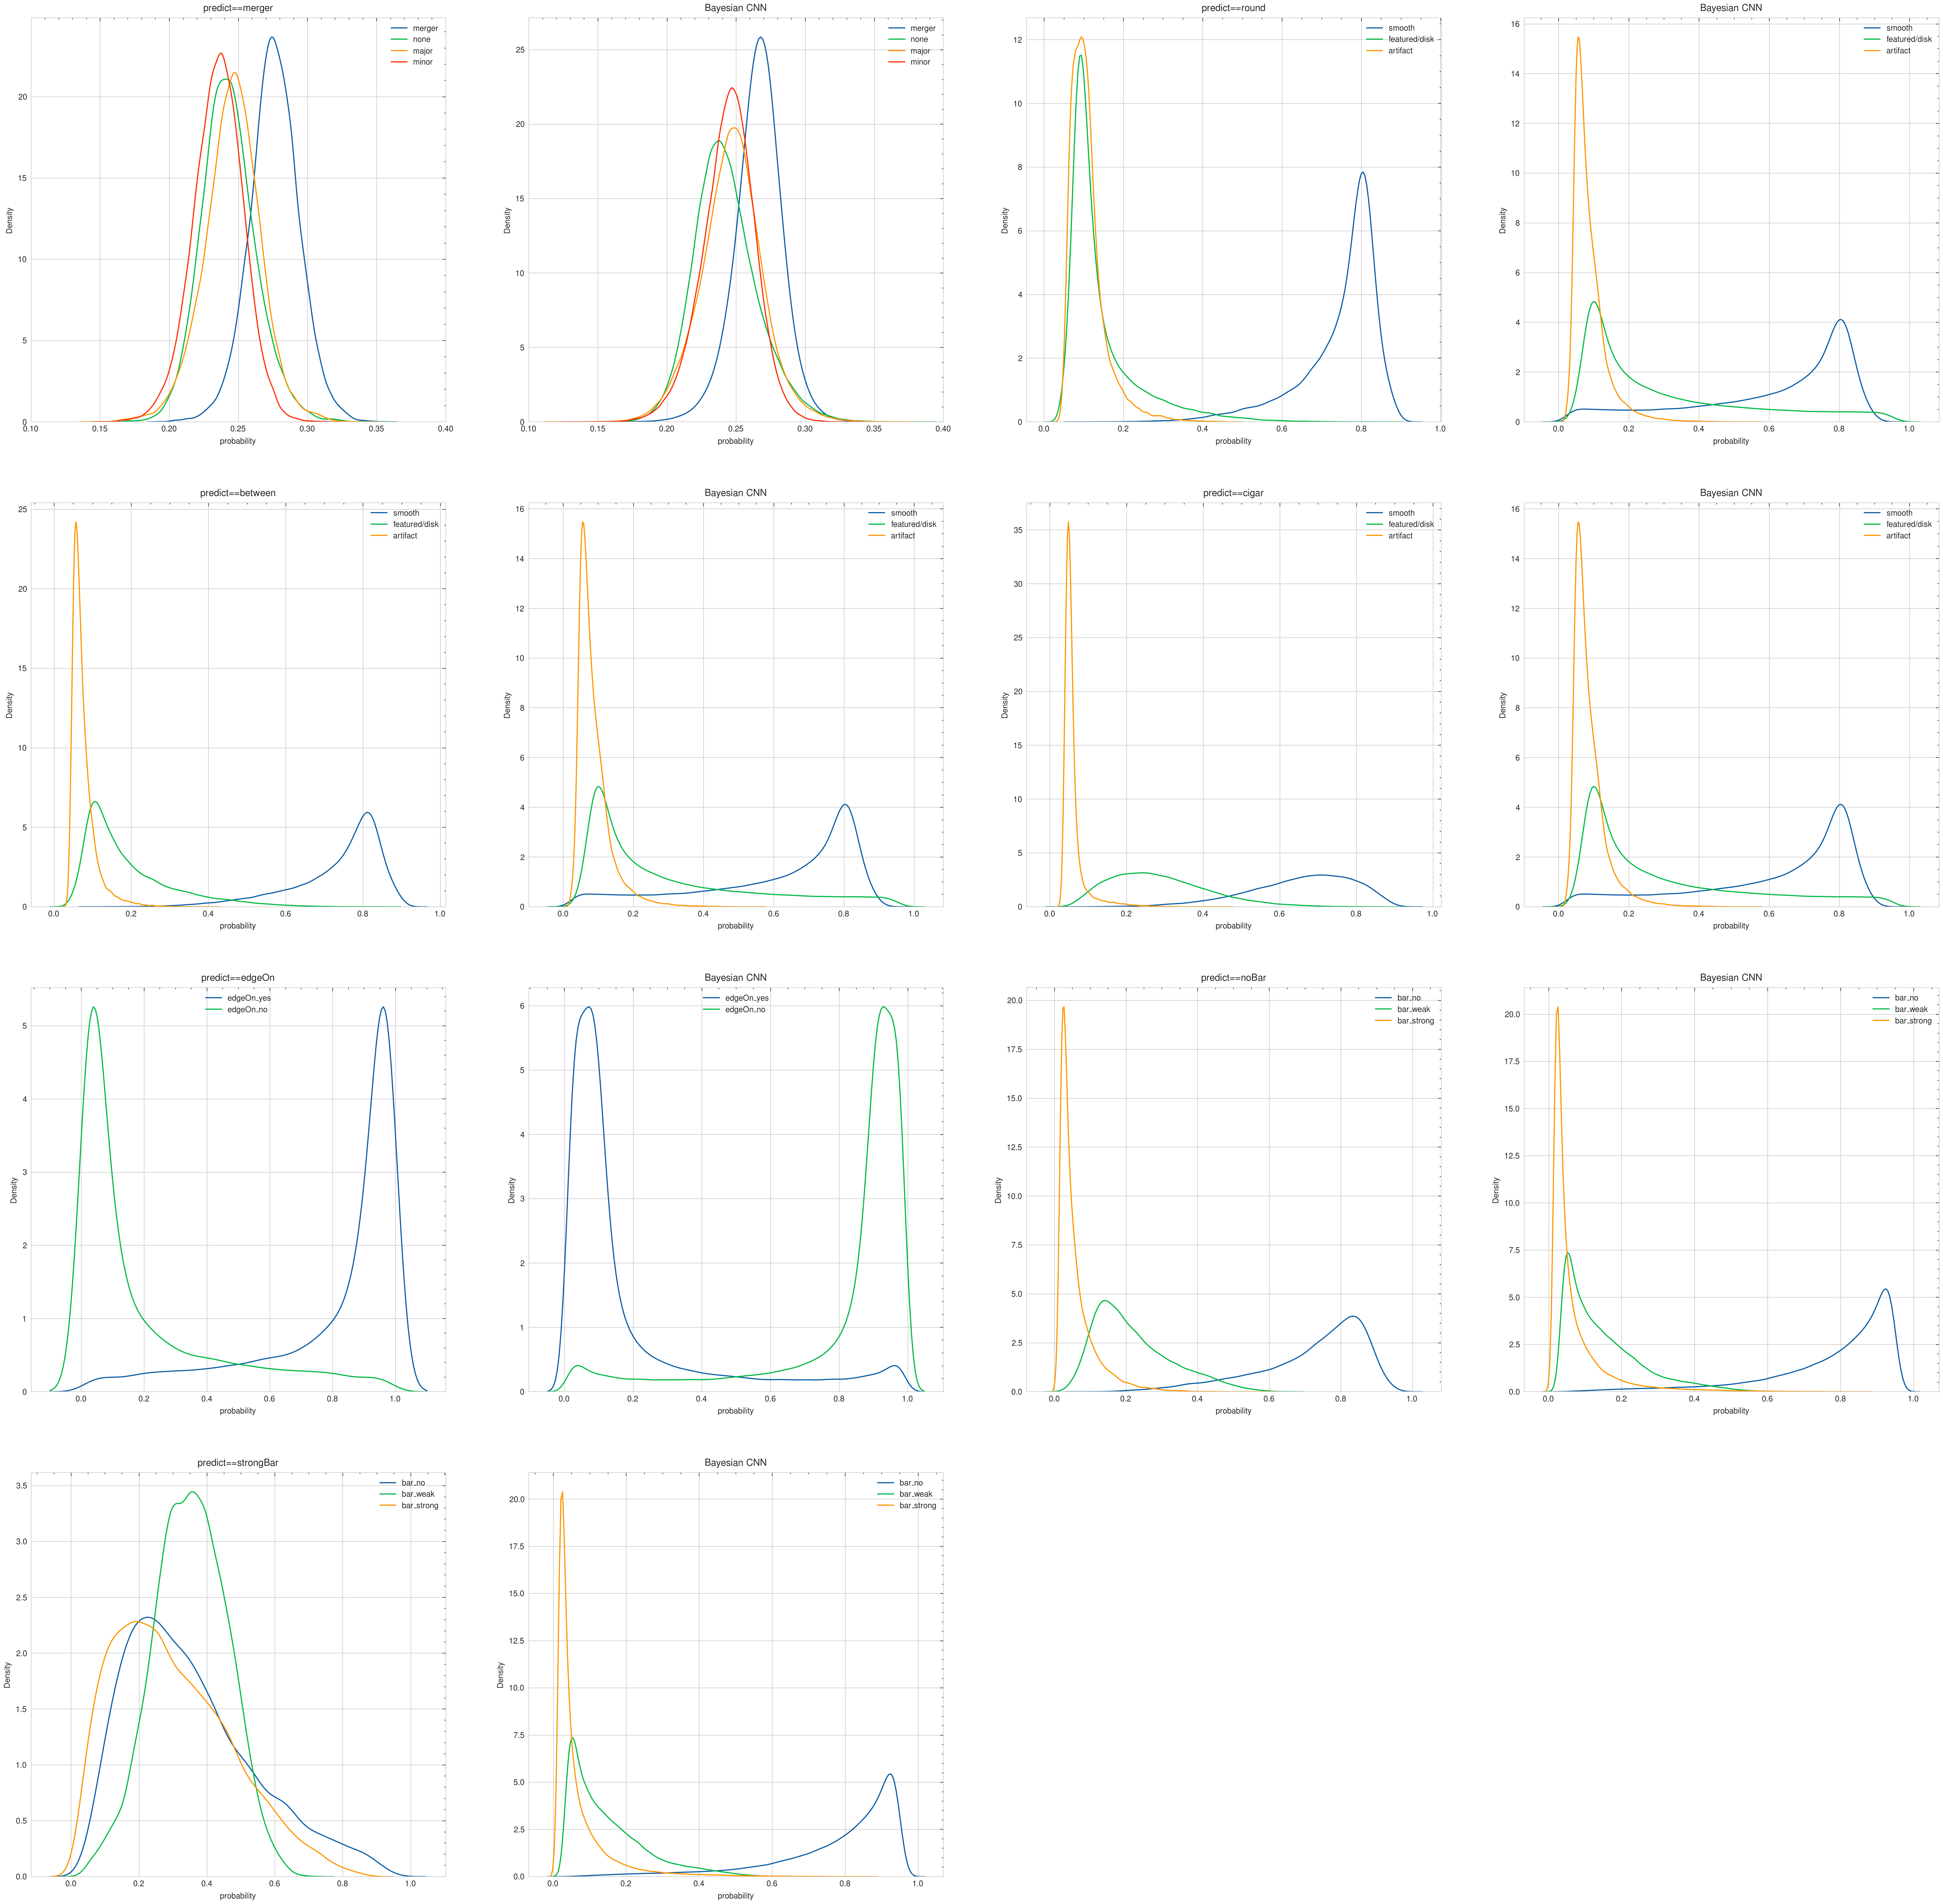

In [18]:
with plt.style.context(['science','nature']):
    plt.figure(figsize=(30, 30), dpi=300)

    plt.subplot(4, 4, 1)
    sns.kdeplot(merger.merging_merger, x="probability")
    sns.kdeplot(merger.merging_none, x="probability")
    sns.kdeplot(merger.merging_major_disturbance, x="probability")
    sns.kdeplot(merger.merging_minor_disturbance, x="probability")
    plt.legend(labels=["merger", "none", "major", "minor"])
    plt.title("predict==merger")
    plt.xlabel("probability")
    plt.xlim((0.1,0.4))

    plt.subplot(4, 4, 2)
    sns.kdeplot(pred.merging_merger, x="probability", bw_adjust=2, legend="de")
    sns.kdeplot(pred.merging_none, x="probability")
    sns.kdeplot(pred.merging_major_disturbance, x="probability")
    sns.kdeplot(pred.merging_minor_disturbance, x="probability")
    plt.legend(labels=["merger", "none", "major", "minor"])
    plt.title("Bayesian CNN")
    plt.xlabel("probability")
    plt.xlim((0.1,0.4))

    plt.subplot(4, 4, 3)
    sns.kdeplot(round.smooth_or_featured_smooth, x="probability")
    sns.kdeplot(round.smooth_or_featured_featured_or_disk, x="probability")
    sns.kdeplot(round.smooth_or_featured_artifact, x="probability")
    plt.legend(labels=["smooth", "featured/disk", "artifact"])
    plt.title("predict==round")
    plt.xlabel("probability")

    plt.subplot(4, 4, 4)
    sns.kdeplot(pred.smooth_or_featured_smooth, x="probability")
    sns.kdeplot(pred.smooth_or_featured_featured_or_disk, x="probability")
    sns.kdeplot(pred.smooth_or_featured_artifact, x="probability")
    plt.legend(labels=["smooth", "featured/disk", "artifact"])
    plt.title("Bayesian CNN")
    plt.xlabel("probability")


    plt.subplot(4, 4, 5)
    sns.kdeplot(between.smooth_or_featured_smooth, x="probability")
    sns.kdeplot(between.smooth_or_featured_featured_or_disk, x="probability")
    sns.kdeplot(between.smooth_or_featured_artifact, x="probability")
    plt.legend(labels=["smooth", "featured/disk", "artifact"])
    plt.title("predict==between")
    plt.xlabel("probability")

    plt.subplot(4, 4, 6)
    sns.kdeplot(pred.smooth_or_featured_smooth, x="probability")
    sns.kdeplot(pred.smooth_or_featured_featured_or_disk, x="probability")
    sns.kdeplot(pred.smooth_or_featured_artifact, x="probability")
    plt.legend(labels=["smooth", "featured/disk", "artifact"])
    plt.title("Bayesian CNN")
    plt.xlabel("probability")



    plt.subplot(4, 4, 7)
    sns.kdeplot(cigar.smooth_or_featured_smooth, x="probability")
    sns.kdeplot(cigar.smooth_or_featured_featured_or_disk, x="probability")
    sns.kdeplot(cigar.smooth_or_featured_artifact, x="probability")
    plt.legend(labels=["smooth", "featured/disk", "artifact"])
    plt.title("predict==cigar")
    plt.xlabel("probability")


    plt.subplot(4, 4, 8)
    sns.kdeplot(pred.smooth_or_featured_smooth, x="probability")
    sns.kdeplot(pred.smooth_or_featured_featured_or_disk, x="probability")
    sns.kdeplot(pred.smooth_or_featured_artifact, x="probability")
    plt.legend(labels=["smooth", "featured/disk", "artifact"])
    plt.title("Bayesian CNN")
    plt.xlabel("probability")


    plt.subplot(4, 4, 9)
    sns.kdeplot(edgeOn.disk_edge_on_yes, x="probability")
    sns.kdeplot(edgeOn.disk_edge_on_no, x="probability")
    plt.legend(labels=["edgeOn_yes", "edgeOn_no"])
    plt.title("predict==edgeOn")
    plt.xlabel("probability")


    plt.subplot(4, 4, 10)
    sns.kdeplot(pred.disk_edge_on_yes, x="probability")
    sns.kdeplot(pred.disk_edge_on_no, x="probability")
    plt.legend(labels=["edgeOn_yes", "edgeOn_no"])
    plt.title("Bayesian CNN")
    plt.xlabel("probability")

    plt.subplot(4, 4, 11)
    sns.kdeplot(noBar.bar_no, x="probability")
    sns.kdeplot(noBar.bar_weak, x="probability")
    sns.kdeplot(noBar.bar_strong, x="probability")
    plt.legend(labels=["bar_no", "bar_weak", "bar_strong"])
    plt.title("predict==noBar")
    plt.xlabel("probability")

    plt.subplot(4, 4, 12)
    sns.kdeplot(pred.bar_no, x="probability")
    sns.kdeplot(pred.bar_weak, x="probability")
    sns.kdeplot(pred.bar_strong, x="probability")
    plt.legend(labels=["bar_no", "bar_weak", "bar_strong"])
    plt.title("Bayesian CNN")
    plt.xlabel("probability")

    plt.subplot(4, 4, 13)
    sns.kdeplot(strongBar.bar_no, x="probability")
    sns.kdeplot(strongBar.bar_weak, x="probability")
    sns.kdeplot(strongBar.bar_strong, x="probability")
    plt.legend(labels=["bar_no", "bar_weak", "bar_strong"])
    plt.title("predict==strongBar")
    plt.xlabel("probability")

    plt.subplot(4, 4, 14)
    sns.kdeplot(pred.bar_no, x="probability")
    sns.kdeplot(pred.bar_weak, x="probability")
    sns.kdeplot(pred.bar_strong, x="probability")
    plt.legend(labels=["bar_no", "bar_weak", "bar_strong"])
    plt.title("Bayesian CNN")
    plt.xlabel("probability")
    plt.savefig("/data/renhaoye/combine.jpg")
    plt.show()

In [15]:
merger

,loc,smooth_or_featured_smooth,smooth_or_featured_featured_or_disk,smooth_or_featured_artifact,disk_edge_on_yes,disk_edge_on_no,has_spiral_arms_yes,has_spiral_arms_no,bar_strong,bar_weak,...,spiral_arm_count_2,spiral_arm_count_3,spiral_arm_count_4,spiral_arm_count_more_than_4,spiral_arm_count_cant_tell,merging_none,merging_minor_disturbance,merging_major_disturbance,merging_merger,pred
2,171.39329952623024_40.51154796601937.fits,0.638978,0.280537,0.080485,0.070545,0.929455,0.289007,0.710993,0.033612,0.096935,...,0.033659,0.006964,0.334585,0.320895,0.266932,0.245988,0.220997,0.264667,0.268348,0
8,214.84566067439042_58.94836588187049.fits,0.509086,0.295118,0.195797,0.062991,0.937009,0.074486,0.925514,0.041206,0.070448,...,0.027641,0.009598,0.264650,0.391130,0.288603,0.257975,0.228855,0.243376,0.269794,0
10,202.9980923986139_34.0657630160039.fits,0.206091,0.718026,0.075883,0.362911,0.637089,0.550462,0.449538,0.291560,0.242927,...,0.073294,0.006586,0.293346,0.349285,0.254044,0.275098,0.199160,0.235666,0.290077,0
12,233.40307752266932_37.4535590231654.fits,0.591326,0.197896,0.210778,0.039387,0.960613,0.032718,0.967282,0.018327,0.036808,...,0.037068,0.012148,0.287481,0.355672,0.267581,0.236016,0.257495,0.244126,0.262363,0
19,133.18606224251417_58.99573521573022.fits,0.638416,0.248781,0.112803,0.076509,0.923491,0.034029,0.965971,0.047100,0.066113,...,0.059991,0.011628,0.290522,0.342081,0.266154,0.238357,0.216649,0.255809,0.289184,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259287,198.15016838284217_51.10408545594513.fits,0.415355,0.405814,0.178831,0.035228,0.964773,0.210032,0.789968,0.036742,0.073053,...,0.042577,0.006471,0.321470,0.354975,0.241681,0.232253,0.217867,0.229344,0.320537,0
259291,135.65204449092283_40.94861609733188.fits,0.810319,0.112545,0.077135,0.077836,0.922164,0.036938,0.963062,0.017484,0.034590,...,0.081068,0.010298,0.294344,0.322750,0.255093,0.248961,0.247064,0.251677,0.252298,0
259295,113.04950052872948_41.536536120882225.fits,0.706156,0.135301,0.158544,0.063349,0.936651,0.082846,0.917154,0.050030,0.099386,...,0.046517,0.011087,0.288351,0.369771,0.258111,0.266400,0.236578,0.248471,0.248551,0
259311,168.19158137612817_42.357185914039995.fits,0.697125,0.216921,0.085954,0.055659,0.944341,0.394271,0.605729,0.070685,0.235250,...,0.078895,0.006129,0.287932,0.294626,0.259241,0.239676,0.238094,0.249131,0.273099,0


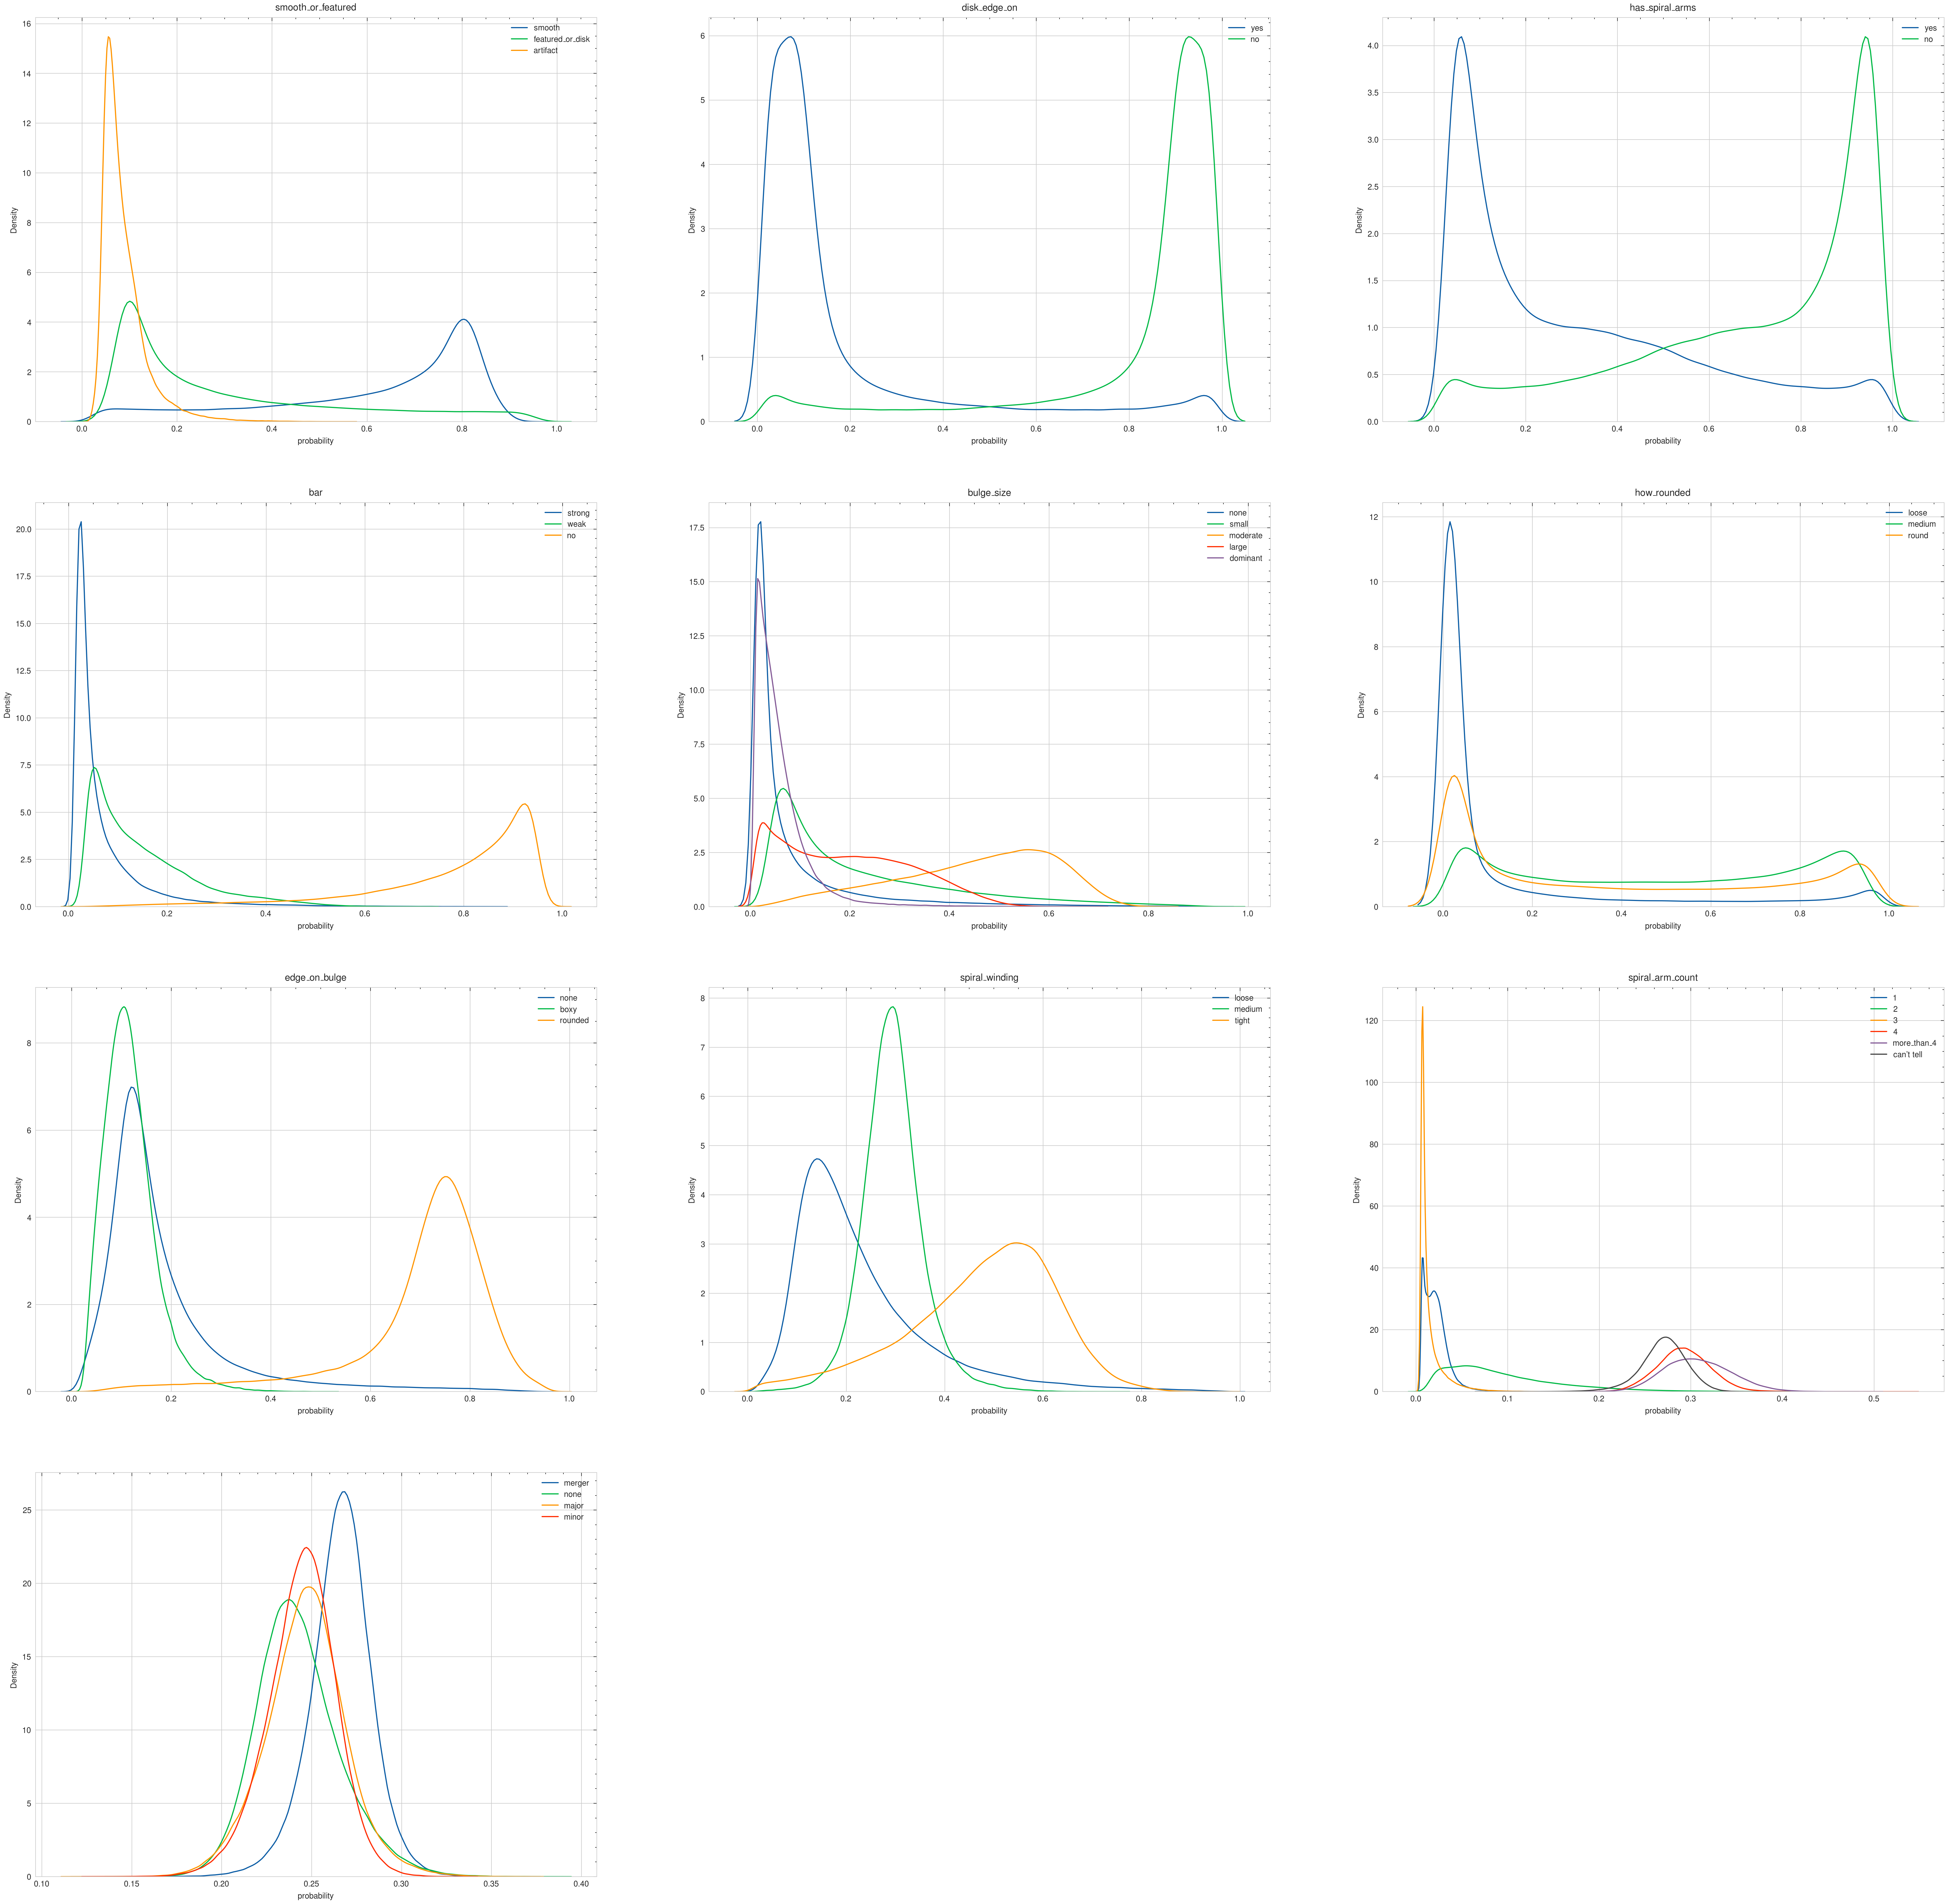

In [16]:
with plt.style.context(['science','nature']):
    plt.figure(figsize=(30, 30), dpi=300)
    plt.title("Bayesian CNN")

    plt.subplot(4, 3, 1)
    sns.kdeplot(pred.smooth_or_featured_smooth, x="probability")
    sns.kdeplot(pred.smooth_or_featured_featured_or_disk, x="probability")
    sns.kdeplot(pred.smooth_or_featured_artifact, x="probability")
    plt.legend(labels=["smooth", "featured_or_disk", "artifact"])
    plt.title("smooth_or_featured")
    plt.xlabel("probability")

    plt.subplot(4, 3, 2)
    sns.kdeplot(pred.disk_edge_on_yes, x="probability")
    sns.kdeplot(pred.disk_edge_on_no, x="probability")
    plt.legend(labels=["yes", "no"])
    plt.title("disk_edge_on")
    plt.xlabel("probability")

    plt.subplot(4, 3, 3)
    sns.kdeplot(pred.has_spiral_arms_yes, x="probability")
    sns.kdeplot(pred.has_spiral_arms_no, x="probability")
    plt.legend(labels=["yes", "no"])
    plt.title("has_spiral_arms")
    plt.xlabel("probability")

    plt.subplot(4, 3, 4)
    sns.kdeplot(pred.bar_strong, x="probability")
    sns.kdeplot(pred.bar_weak, x="probability")
    sns.kdeplot(pred.bar_no, x="probability")
    plt.legend(labels=["strong", "weak", "no"])
    plt.title("bar")
    plt.xlabel("probability")

    plt.subplot(4, 3, 5)
    sns.kdeplot(pred.bulge_size_none, x="probability")
    sns.kdeplot(pred.bulge_size_small, x="probability")
    sns.kdeplot(pred.bulge_size_moderate, x="probability")
    sns.kdeplot(pred.bulge_size_large, x="probability")
    sns.kdeplot(pred.bulge_size_dominant, x="probability")
    plt.legend(labels=["none", "small", "moderate", "large", "dominant"])
    plt.title("bulge_size")
    plt.xlabel("probability")

    plt.subplot(4, 3, 6)
    sns.kdeplot(pred.how_rounded_loose, x="probability")
    sns.kdeplot(pred.how_rounded_medium, x="probability")
    sns.kdeplot(pred.how_rounded_round, x="probability")
    plt.legend(labels=["loose", "medium", "round"])
    plt.title("how_rounded")
    plt.xlabel("probability")

    plt.subplot(4, 3, 7)
    sns.kdeplot(pred.edge_on_bulge_none, x="probability")
    sns.kdeplot(pred.edge_on_bulge_boxy, x="probability")
    sns.kdeplot(pred.edge_on_bulge_rounded, x="probability")
    plt.legend(labels=["none", "boxy", "rounded"])
    plt.title("edge_on_bulge")
    plt.xlabel("probability")

    plt.subplot(4, 3, 8)
    sns.kdeplot(pred.spiral_winding_loose, x="probability")
    sns.kdeplot(pred.spiral_winding_medium, x="probability")
    sns.kdeplot(pred.spiral_winding_tight, x="probability")
    plt.legend(labels=["loose", "medium", "tight"])
    plt.title("spiral_winding")
    plt.xlabel("probability")

    plt.subplot(4, 3, 9)
    sns.kdeplot(pred.spiral_arm_count_1, x="probability")
    sns.kdeplot(pred.spiral_arm_count_2, x="probability")
    sns.kdeplot(pred.spiral_arm_count_3, x="probability")
    sns.kdeplot(pred.spiral_arm_count_4, x="probability")
    sns.kdeplot(pred.spiral_arm_count_more_than_4, x="probability")
    sns.kdeplot(pred.spiral_arm_count_cant_tell, x="probability")
    plt.legend(labels=["1", "2", "3", "4", "more_than_4", "can't tell"])
    plt.title("spiral_arm_count")
    plt.xlabel("probability")

    plt.subplot(4, 3, 10)
    sns.kdeplot(pred.merging_merger, x="probability")
    sns.kdeplot(pred.merging_none, x="probability")
    sns.kdeplot(pred.merging_major_disturbance, x="probability")
    sns.kdeplot(pred.merging_minor_disturbance, x="probability")
    plt.legend(labels=["merger", "none", "major", "minor"])
    plt.title("")
    plt.xlabel("probability")


    plt.savefig("/data/renhaoye/BayesianCNN.jpg")
    plt.show()

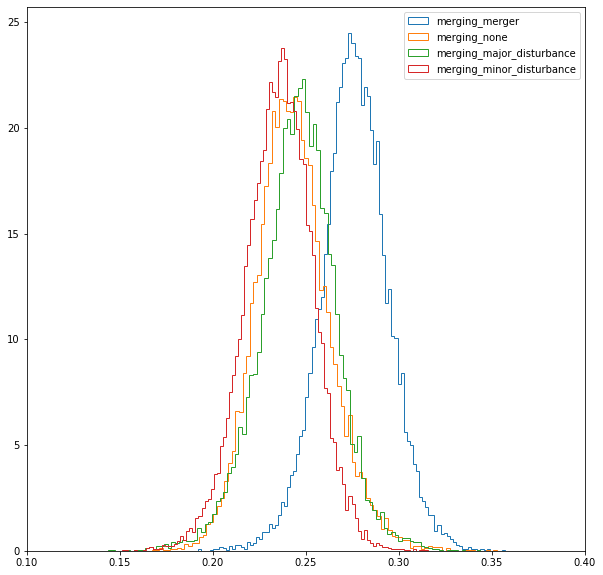

In [18]:
plt.figure(figsize=(10, 10))
plt.hist(merger.merging_merger, density=True, bins=100, histtype="step", label="merging_merger")
plt.hist(merger.merging_none, density=True, bins=100, histtype="step", label="merging_none")
plt.hist(merger.merging_major_disturbance, density=True, bins=100, histtype="step", label="merging_major_disturbance")
plt.hist(merger.merging_minor_disturbance, density=True, bins=100, histtype="step", label="merging_minor_disturbance")
plt.legend(fontsize=10)
plt.xlim((0.1,0.4))
# plt.ylim(0,40)
plt.show()

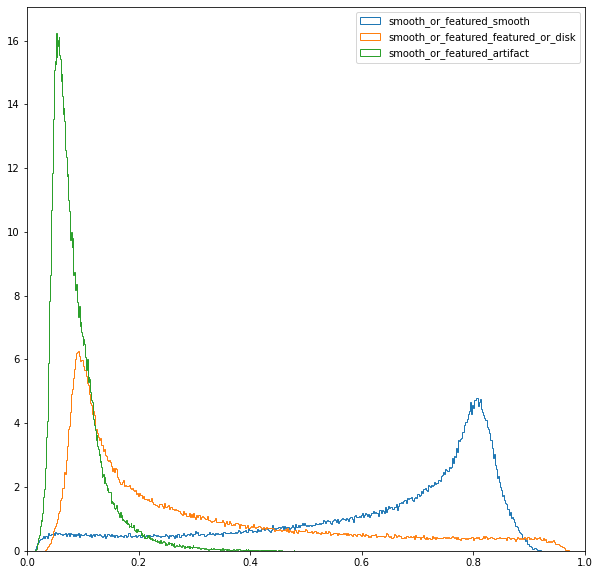

In [19]:
plt.figure(figsize=(10, 10))
plt.hist(pred.smooth_or_featured_smooth, density=True, bins=500, histtype="step", label="smooth_or_featured_smooth")
plt.hist(pred.smooth_or_featured_featured_or_disk, density=True, bins=500, histtype="step", label="smooth_or_featured_featured_or_disk")
plt.hist(pred.smooth_or_featured_artifact, density=True, bins=500, histtype="step", label="smooth_or_featured_artifact")
plt.legend(fontsize=10)
plt.xlim((0,1))
# plt.ylim(0,40)
plt.show()

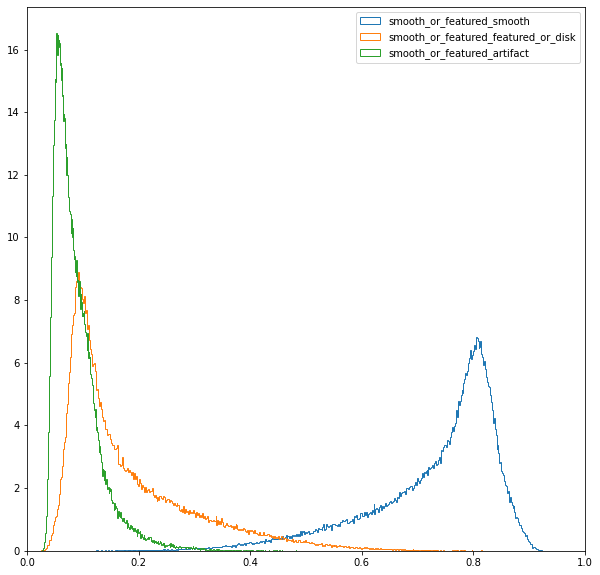

In [8]:
plt.figure(figsize=(10, 10))
plt.hist(smooth.smooth_or_featured_smooth, density=True, bins=500, histtype="step", label="smooth_or_featured_smooth")
plt.hist(smooth.smooth_or_featured_featured_or_disk, density=True, bins=500, histtype="step", label="smooth_or_featured_featured_or_disk")
plt.hist(smooth.smooth_or_featured_artifact, density=True, bins=500, histtype="step", label="smooth_or_featured_artifact")
plt.legend(fontsize=10)
plt.xlim((0,1))
# plt.ylim(0,40)
plt.show()

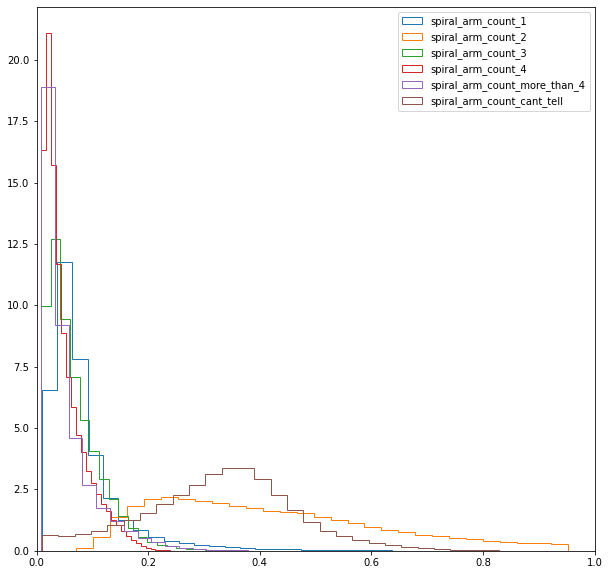

In [20]:
plt.figure(figsize=(10, 10))
# plt.hist(smooth.smooth_or_featured_smooth, density=True, bins=500, histtype="step", label="smooth_or_featured_smooth")
# plt.hist(smooth.smooth_or_featured_featured_or_disk, density=True, bins=500, histtype="step", label="smooth_or_featured_featured_or_disk")
# plt.hist(smooth.smooth_or_featured_artifact, density=True, bins=500, histtype="step", label="smooth_or_featured_artifact")
# plt.hist(pred.disk_edge_on_yes, density=True, bins=30, histtype="step", label="disk_edge_on_yes")
# plt.hist(pred.disk_edge_on_no, density=True, bins=30, histtype="step", label="disk_edge_on_no")
# plt.hist(pred.has_spiral_arms_yes, density=True, bins=30, histtype="step", label="has_spiral_arms_yes")
# plt.hist(pred.has_spiral_arms_no, density=True, bins=30, histtype="step", label="has_spiral_arms_no")
# plt.hist(pred.bar_strong, density=True, bins=30, histtype="step", label="bar_strong")
# plt.hist(pred.bar_weak, density=True, bins=30, histtype="step", label="bar_weak")
# plt.hist(pred.bar_no, density=True, bins=30, histtype="step", label="bar_no")
# plt.hist(pred.bulge_size_dominant, density=True, bins=500, histtype="step", label="bulge_size_dominant")
# plt.hist(pred.bulge_size_large, density=True, bins=500, histtype="step", label="bulge_size_large")
# plt.hist(pred.bulge_size_moderate, density=True, bins=500, histtype="step", label="bulge_size_moderate")
# plt.hist(pred.bulge_size_small, density=True, bins=500, histtype="step", label="bulge_size_small")
# plt.hist(pred.bulge_size_none, density=True, bins=500, histtype="step", label="bulge_size_none")
# plt.hist(pred.how_rounded_round, density=True, bins=30, histtype="step", label="how_rounded_round")
# plt.hist(pred.how_rounded_medium, density=True, bins=30, histtype="step", label="how_rounded_medium")
# plt.hist(pred.how_rounded_loose, density=True, bins=30, histtype="step", label="how_rounded_loose")
plt.hist(pred.spiral_arm_count_1, density=True, bins=30, histtype="step", label="spiral_arm_count_1")
plt.hist(pred.spiral_arm_count_2, density=True, bins=30, histtype="step", label="spiral_arm_count_2")
plt.hist(pred.spiral_arm_count_3, density=True, bins=30, histtype="step", label="spiral_arm_count_3")
plt.hist(pred.spiral_arm_count_4, density=True, bins=30, histtype="step", label="spiral_arm_count_4")
plt.hist(pred.spiral_arm_count_more_than_4, density=True, bins=30, histtype="step", label="spiral_arm_count_more_than_4")
plt.hist(pred.spiral_arm_count_cant_tell, density=True, bins=30, histtype="step", label="spiral_arm_count_cant_tell")
plt.legend(fontsize=10)
plt.xlim((0,1))
# plt.ylim(0,40)
plt.show()

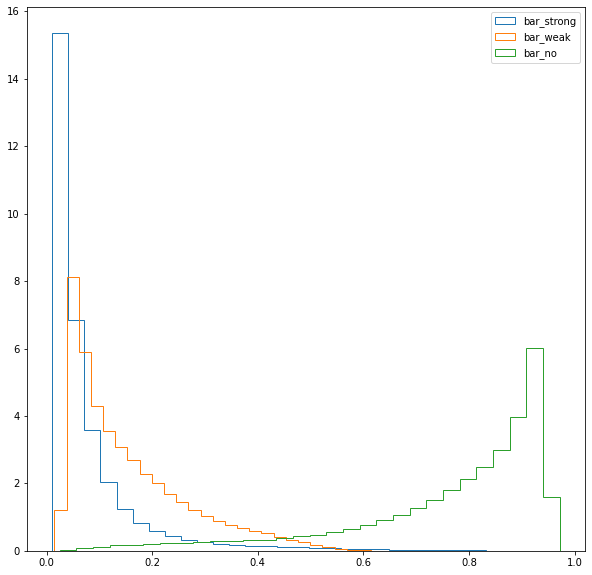

In [10]:
plt.figure(figsize=(10, 10))
# plt.hist(pred.smooth_or_featured_smooth, density=True, bins=30, histtype="step", label="smooth_or_featured_smooth")
# plt.hist(pred.smooth_or_featured_featured_or_disk, density=True, bins=30, histtype="step", label="smooth_or_featured_featured_or_disk")
# plt.hist(pred.smooth_or_featured_artifact, density=True, bins=30, histtype="step", label="smooth_or_featured_artifact")
# plt.hist(pred.disk_edge_on_yes, density=True, bins=30, histtype="step", label="disk_edge_on_yes")
# plt.hist(pred.disk_edge_on_no, density=True, bins=30, histtype="step", label="disk_edge_on_no")
# plt.hist(pred.has_spiral_arms_yes, density=True, bins=30, histtype="step", label="has_spiral_arms_yes")
# plt.hist(pred.has_spiral_arms_no, density=True, bins=30, histtype="step", label="has_spiral_arms_no")
plt.hist(pred.bar_strong, density=True, bins=30, histtype="step", label="bar_strong")
plt.hist(pred.bar_weak, density=True, bins=30, histtype="step", label="bar_weak")
plt.hist(pred.bar_no, density=True, bins=30, histtype="step", label="bar_no")
# plt.hist(pred.bulge_size_dominant, density=True, bins=30, histtype="step", label="bulge_size_dominant")
# plt.hist(pred.bulge_size_large, density=True, bins=30, histtype="step", label="bulge_size_large")
# plt.hist(pred.bulge_size_moderate, density=True, bins=30, histtype="step", label="bulge_size_moderate")
# plt.hist(pred.bulge_size_small, density=True, bins=30, histtype="step", label="bulge_size_small")
# plt.hist(pred.bulge_size_none, density=True, bins=30, histtype="step", label="bulge_size_none")
# plt.hist(pred.how_rounded_round, density=True, bins=30, histtype="step", label="how_rounded_round")
# plt.hist(pred.how_rounded_medium, density=True, bins=30, histtype="step", label="how_rounded_medium")
# plt.hist(pred.how_rounded_loose, density=True, bins=30, histtype="step", label="how_rounded_loose")
# plt.hist(pred.spiral_arm_count_1, density=True, bins=30, histtype="step", label="spiral_arm_count_1")
# plt.hist(pred.spiral_arm_count_2, density=True, bins=30, histtype="step", label="spiral_arm_count_2")
# plt.hist(pred.spiral_arm_count_3, density=True, bins=30, histtype="step", label="spiral_arm_count_3")
# plt.hist(pred.spiral_arm_count_4, density=True, bins=30, histtype="step", label="spiral_arm_count_4")
# plt.hist(pred.spiral_arm_count_more_than_4, density=True, bins=30, histtype="step", label="spiral_arm_count_more_than_4")
# plt.hist(pred.spiral_arm_count_cant_tell, density=True, bins=30, histtype="step", label="spiral_arm_count_cant_tell")
plt.legend(fontsize=10)
# plt.xlim((0.01,1))
# plt.ylim(0,40)
plt.show()

In [19]:
len(pred.query('smooth_or_featured_featured_or_disk > 0.4'))/len(pred)

0.27371400356217046

In [47]:

from pandas import read_parquet
df_auto = read_parquet("/data/renhaoye/MorCG/dataset/gz_decals_auto_posteriors.parquet").rename(columns=lambda x: x.replace("-", "_")) # 头中的-换为_

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline